Expert of SVM -- differents type of voting system

In [1]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 9.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import Dict, List, Tuple
import pickle
import warnings
import optuna
from optuna.samplers import TPESampler
from google.colab import files

warnings.filterwarnings('ignore')


In [4]:
class LearnPPNC:

    def __init__(self, optimize: bool = True, C: float = 10.0, gamma: float = 0.1,
                 n_trials: int = 50, cv_folds: int = 3, verbose: bool = True):
        self.optimize = optimize
        self.default_C = C
        self.default_gamma = gamma
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        self.verbose = verbose
        self.C = C
        self.gamma = gamma
        self.scaler: StandardScaler = None
        self.experts: List[Dict] = []
        self.all_classes: set = set()
        self.is_initialized = False
        self.optuna_study = None
        self.history: List[Dict] = []

    def _log(self, msg: str):
        if self.verbose:
            print(msg)

    def _optimize_hyperparams(self, X: np.ndarray, y: np.ndarray):
        self._log("OPTIMISATION OPTUNA")
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        def objective(trial):
            C = trial.suggest_float('C', 1e-1, 1e4, log=True)
            gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)
            svc = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced')
            scores = cross_val_score(svc, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
            return scores.mean()

        self.optuna_study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42)
        )
        self.optuna_study.optimize(
            objective,
            n_trials=self.n_trials,
            show_progress_bar=self.verbose
        )

        self.C = self.optuna_study.best_params['C']
        self.gamma = self.optuna_study.best_params['gamma']

        self._log(f"\nBest Datas :")
        self._log(f"  C = {self.C:.4f}")
        self._log(f"  gamma = {self.gamma:.6f}")
        self._log(f"  CV Accuracy = {self.optuna_study.best_value:.4f}")

    def add_data(self, X: np.ndarray, y: np.ndarray, name: str = None):
        """
        To create new expert.
        """
        X = np.atleast_2d(X)
        y = np.array(y)
        name = name or f"Batch_{len(self.experts) + 1}"

        classes_in_batch = set(np.unique(y))
        new_classes = classes_in_batch - self.all_classes

        self._log(f"{name}")
        self._log(f"   samples: {len(y)}")
        self._log(f"   Class: {sorted(classes_in_batch)}")
        if new_classes:
            self._log(f"   new class: {sorted(new_classes)}")

        if not self.is_initialized:
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)

            if self.optimize:
                self._optimize_hyperparams(X_scaled, y)
            else:
                self.C = self.default_C
                self.gamma = self.default_gamma
                self._log(f"\nParameters: C={self.C}, gamma={self.gamma}")

            self.is_initialized = True

        X_scaled = self.scaler.transform(X)
        clf = SVC(
            C=self.C,
            gamma=self.gamma,
            kernel='rbf',
            class_weight='balanced',
            probability=True,
            random_state=42
        )
        clf.fit(X_scaled, y)

        y_pred_train = clf.predict(X_scaled)
        accuracy = accuracy_score(y, y_pred_train)

        expert = {
            'clf': clf,
            'accuracy': accuracy,
            'classes': classes_in_batch,
            'name': name,
            'n_sv': len(clf.support_),
            'n_samples': len(y)
        }
        self.experts.append(expert)
        self.all_classes.update(classes_in_batch)

        self.history.append({
            'name': name,
            'n_samples': len(y),
            'n_classes': len(classes_in_batch),
            'new_classes': list(new_classes),
            'accuracy': accuracy,
            'n_sv': len(clf.support_),
            'expert_id': len(self.experts)
        })

        self._log(f"\n✓ Expert #{len(self.experts)} creaeed: {name}")
        self._log(f"   Accuracy (train): {accuracy:.4f}")
        return self

    def predict_with_details(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        X = np.atleast_2d(X)
        X_scaled = self.scaler.transform(X)
        n_samples = X.shape[0]

        all_classes = np.array(sorted(self.all_classes))
        n_classes = len(all_classes)
        class_to_idx = {c: i for i, c in enumerate(all_classes)}

        vote_matrix = np.zeros((n_samples, n_classes))
        prob_matrix = np.zeros((n_samples, n_classes))
        total_weight = 0.0

        for expert in self.experts:
            clf = expert['clf']
            weight = expert['accuracy']
            total_weight += weight

            pred = clf.predict(X_scaled)
            proba = clf.predict_proba(X_scaled)
            expert_classes = clf.classes_

            for i in range(n_samples):
                if pred[i] in class_to_idx:
                    vote_matrix[i, class_to_idx[pred[i]]] += weight
                for j, c in enumerate(expert_classes):
                    if c in class_to_idx:
                        prob_matrix[i, class_to_idx[c]] += weight * proba[i, j]

        prob_matrix /= total_weight
        y_pred = all_classes[np.argmax(vote_matrix, axis=1)]
        confidence = np.max(prob_matrix, axis=1)

        return y_pred, confidence, vote_matrix

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Dict:
        y_pred, confidence, vote_matrix = self.predict_with_details(X)
        all_classes = np.array(sorted(self.all_classes))
        return {
            'accuracy': accuracy_score(y, y_pred),
            'y_true': y,
            'y_pred': y_pred,
            'confidence': confidence,
            'vote_matrix': vote_matrix,
            'confusion_matrix': confusion_matrix(y, y_pred, labels=all_classes),
            'classes': all_classes
        }

In [5]:
def plot_confusion_matrix(results, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(12, 10))

    cm = results['confusion_matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = results['classes']

    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes.astype(int),
                yticklabels=classes.astype(int),
                ax=ax, vmin=0, vmax=1,
                cbar_kws={'label': 'Proportion'})

    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Real Class', fontsize=12)
    ax.set_title(f"{title}\nAccuracy: {results['accuracy']:.2%}", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()


In [6]:
FEATURE_COLS = [
    'Electrical speed [rad/s]',
    'I_M_a', 'I_M_b', 'I_M_c',
    'I_P_a', 'I_P_b', 'I_P_c',
    'I_B_a', 'I_B_b', 'I_B_c',
    'V_M_a', 'V_M_b', 'V_M_c',
    'V_P_a', 'V_P_b', 'V_P_c',
    'V_B_a', 'V_B_b', 'V_B_c'
]
LABEL_COL = 'Class label'

def load_file(filepath):

    df = pd.read_csv(filepath)
    X = df[FEATURE_COLS].values
    y = df[LABEL_COL].values
    print(f"file: {len(y)} samples, {len(np.unique(y))} classes")
    print(f"Classes: {sorted(np.unique(y))}")
    return X, y, df

In [7]:
print("file:")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
X_all, y_all, df = load_file(file_name)

for c in sorted(np.unique(y_all)):
    print(f"  Classes {c:2d} : {np.sum(y_all == c):4d} samples")

file:


Saving data_exp8.csv to data_exp8.csv
file: 6796 samples, 16 classes
Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
  Classes  1 :   45 samples
  Classes  2 :  446 samples
  Classes  3 :  450 samples
  Classes  4 :  455 samples
  Classes  5 :  450 samples
  Classes  6 :  450 samples
  Classes  7 :  450 samples
  Classes  8 :  450 samples
  Classes  9 :  450 samples
  Classes 10 :  450 samples
  Classes 11 :  450 samples
  Classes 12 :  450 samples
  Classes 13 :  450 samples
  Classes 14 :  450 samples
  Classes 15 :  450 samples
  Classes 16 :  450 samples


In [8]:
KNOWN_CLASSES = [1, 2, 3, 4, 5, 6, 7, 8]
NEW_CLASSES   = [9, 10, 11, 12, 13, 14, 15, 16]


mask_known = np.isin(y_all, KNOWN_CLASSES)
mask_new   = np.isin(y_all, NEW_CLASSES)

X_known = X_all[mask_known]
y_known = y_all[mask_known]
X_new = X_all[mask_new]
y_new = y_all[mask_new]

X_known_train, X_known_test, y_known_train, y_known_test = train_test_split(
    X_known, y_known, test_size=0.2, stratify=y_known, random_state=42
)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X_new, y_new, test_size=0.2, stratify=y_new, random_state=42
)

X_test_all = np.vstack([X_known_test, X_new_test])
y_test_all = np.hstack([y_known_test, y_new_test])

print(f"\nKnown - Train: {len(y_known_train)}, Test: {len(y_known_test)}")
print(f"New   - Train: {len(y_new_train)},   Test: {len(y_new_test)}")
print(f"Test total:    {len(y_test_all)}")


Known - Train: 2556, Test: 640
New   - Train: 2880,   Test: 720
Test total:    1360


In [9]:
#Incremental learning
model = LearnPPNC(optimize=True, n_trials=100, cv_folds=3, verbose=True)


In [10]:
model.add_data(X_known_train, y_known_train, name="Expert_1_Known")

[I 2026-02-24 16:01:06,668] A new study created in memory with name: no-name-4b06c6ed-bf91-406e-98b7-0825bf6c3d84


Expert_1_Known
   samples: 2556
   Class: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
   new class: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
OPTIMISATION OPTUNA


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-24 16:01:09,769] Trial 0 finished with value: 0.9166666666666666 and parameters: {'C': 7.4593432857265505, 'gamma': 5.669849511478847}. Best is trial 0 with value: 0.9166666666666666.
[I 2026-02-24 16:01:10,180] Trial 1 finished with value: 0.927621283255086 and parameters: {'C': 457.0563099801454, 'gamma': 0.09846738873614563}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-24 16:01:11,107] Trial 2 finished with value: 0.19209702660406883 and parameters: {'C': 0.6026889128682511, 'gamma': 0.000602521573620386}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-24 16:01:12,035] Trial 3 finished with value: 0.6850547730829422 and parameters: {'C': 0.195172246414495, 'gamma': 2.1423021757741068}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-24 16:01:12,413] Trial 4 finished with value: 0.933489827856025 and parameters: {'C': 101.29197956845728, 'gamma': 0.3470266988650412}. Best is trial 4 with value: 0.933489827856025.
[I 2026-02-24 16:01:13,37

In [11]:
print("Test on E1")
results_e1 = model.evaluate(X_known_test, y_known_test)
print(f"\nACCURACY E1: {results_e1['accuracy']:.4f}")
print(classification_report(results_e1['y_true'], results_e1['y_pred'], zero_division=0))

Test on E1

ACCURACY E1: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00        90
           4       1.00      1.00      1.00        91
           5       1.00      1.00      1.00        90
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        90

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



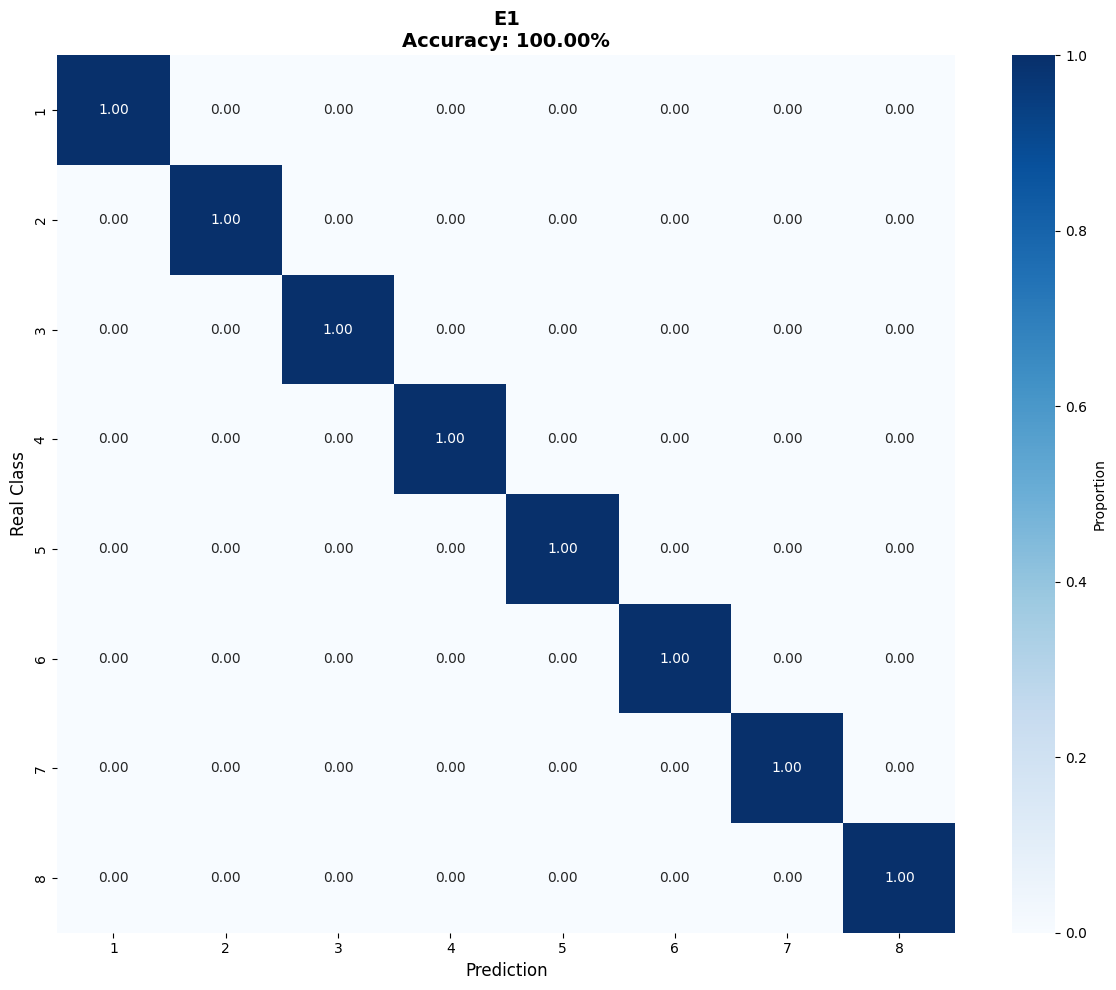

In [12]:
plot_confusion_matrix(results_e1, 'E1')

In [13]:
model.add_data(X_new_train, y_new_train, name="Expert_2_New")

print(f"\nexpert number: {len(model.experts)}")
print(f"total classes: {sorted(model.all_classes)}")

Expert_2_New
   samples: 2880
   Class: [np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
   new class: [np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]

✓ Expert #2 creaeed: Expert_2_New
   Accuracy (train): 0.9771

expert number: 2
total classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]


comparison of vote methods


In [14]:

print("basic voting ")

results_basic = model.evaluate(X_test_all, y_test_all)
acc_basic = results_basic['accuracy']
y_pred_basic = results_basic['y_pred']

print(f"\nACCURACY = {acc_basic:.4f}")
print(classification_report(y_test_all, y_pred_basic, zero_division=0))

basic voting 

ACCURACY = 0.4706
              precision    recall  f1-score   support

           1       0.08      1.00      0.15         9
           2       1.00      1.00      1.00        90
           3       0.55      1.00      0.71        90
           4       1.00      1.00      1.00        91
           5       0.52      1.00      0.69        90
           6       0.40      1.00      0.57        90
           7       0.73      1.00      0.84        90
           8       0.23      1.00      0.38        90
           9       0.00      0.00      0.00        90
          10       0.00      0.00      0.00        90
          11       0.00      0.00      0.00        90
          12       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        90
          14       0.00      0.00      0.00        90
          15       0.00      0.00      0.00        90
          16       0.00      0.00      0.00        90

    accuracy                           0.47    

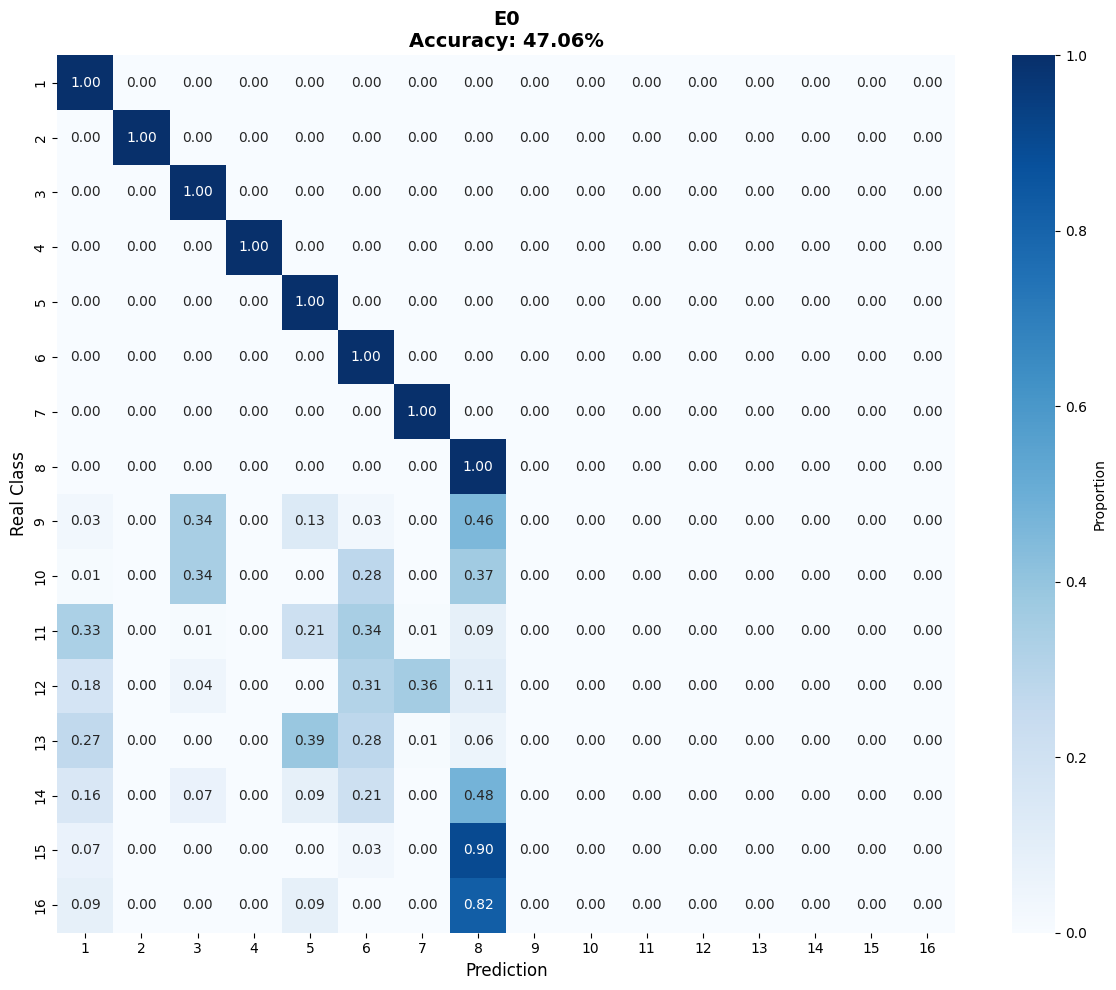

In [15]:
plot_confusion_matrix(results_basic, 'E0')

In [16]:
print("DW-CAV")


ALL_CLASSES = np.array(sorted(model.all_classes))
n_classes = len(ALL_CLASSES)
class_to_idx = {c: i for i, c in enumerate(ALL_CLASSES)}
n_test = len(y_test_all)

X_test_sc = model.scaler.transform(X_test_all)

vote_dwcav = np.zeros((n_test, n_classes))

for exp in model.experts:
    clf = exp['clf']
    w = exp['accuracy']
    known = exp['classes']
    proba = clf.predict_proba(X_test_sc)
    expert_classes = clf.classes_

    for i in range(n_test):
        for j, c in enumerate(expert_classes):
            if c in class_to_idx and c in known:
                vote_dwcav[i, class_to_idx[c]] += w * proba[i, j]

y_pred_dwcav = ALL_CLASSES[np.argmax(vote_dwcav, axis=1)]
acc_dwcav = accuracy_score(y_test_all, y_pred_dwcav)

print(f"\nACCURACY = {acc_dwcav:.4f}")
print(classification_report(y_test_all, y_pred_dwcav, zero_division=0))

DW-CAV

ACCURACY = 0.8404
              precision    recall  f1-score   support

           1       0.13      0.89      0.22         9
           2       1.00      0.99      0.99        90
           3       1.00      1.00      1.00        90
           4       1.00      0.98      0.99        91
           5       1.00      0.89      0.94        90
           6       0.83      1.00      0.91        90
           7       1.00      0.88      0.93        90
           8       0.43      0.99      0.60        90
           9       0.94      0.87      0.90        90
          10       1.00      0.91      0.95        90
          11       0.99      0.83      0.90        90
          12       1.00      0.78      0.88        90
          13       1.00      0.73      0.85        90
          14       1.00      0.78      0.88        90
          15       0.86      0.53      0.66        90
          16       0.78      0.44      0.57        90

    accuracy                           0.84      1360


In [21]:
print("+E2 Transfert SVs ")

# Extraire les SVs de Expert 1 voir sklearn
expert1_clf = model.experts[0]['clf']
X_known_train_sc = model.scaler.transform(X_known_train)
sv_indices = expert1_clf.support_
X_sv1 = X_known_train_sc[sv_indices]
y_sv1 = y_known_train[sv_indices]

print(f"SVs from E1: {len(y_sv1)}")
print(f"Classes inside SVs: {sorted(np.unique(y_sv1))}")

# E2 = old SVs + new data
X_new_train_sc = model.scaler.transform(X_new_train)
X_e2_transfer = np.vstack([X_sv1, X_new_train_sc])
y_e2_transfer = np.hstack([y_sv1, y_new_train])


expert2_transfer = SVC(
    C=model.C, gamma=model.gamma, kernel='rbf',
    class_weight='balanced', probability=True, random_state=42
)
expert2_transfer.fit(X_e2_transfer, y_e2_transfer)
acc2_tr_train = accuracy_score(y_e2_transfer, expert2_transfer.predict(X_e2_transfer))
print(f"Train accuracy: {acc2_tr_train:.4f}, SVs: {len(expert2_transfer.support_)}")

y_pred_transfer = expert2_transfer.predict(X_test_sc)
acc_transfer = accuracy_score(y_test_all, y_pred_transfer)

print(f"\nACCURACY = {acc_transfer:.4f}")
print(classification_report(y_test_all, y_pred_transfer, zero_division=0))

+E2 Transfert SVs 
SVs from E1: 888
Classes inside SVs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Train accuracy: 0.9705, SVs: 1968

ACCURACY = 0.9713
              precision    recall  f1-score   support

           1       0.20      1.00      0.33         9
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00        90
           4       1.00      1.00      1.00        91
           5       1.00      1.00      1.00        90
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        90
           9       1.00      1.00      1.00        90
          10       1.00      1.00      1.00        90
          11       1.00      0.89      0.94        90
          12       0.99      0.87      0.92        90
          13       1.00      0.91      0.95        90
          14       1.00      

In [22]:

print("DW-CAV + Transfert SVs")
vote_dwcav_tr = np.zeros((n_test, n_classes))

#E1
proba1 = expert1_clf.predict_proba(X_test_sc)
ec1 = expert1_clf.classes_
w1 = model.experts[0]['accuracy']
for i in range(n_test):
    for j, c in enumerate(ec1):
        if c in class_to_idx and c in set(KNOWN_CLASSES):
            vote_dwcav_tr[i, class_to_idx[c]] += w1 * proba1[i, j]

# E2
proba2 = expert2_transfer.predict_proba(X_test_sc)
ec2 = expert2_transfer.classes_
w2 = acc2_tr_train
for i in range(n_test):
    for j, c in enumerate(ec2):
        if c in class_to_idx:
            vote_dwcav_tr[i, class_to_idx[c]] += w2 * proba2[i, j]

y_pred_dwcav_tr = ALL_CLASSES[np.argmax(vote_dwcav_tr, axis=1)]
acc_dwcav_tr = accuracy_score(y_test_all, y_pred_dwcav_tr)

print(f"\nACCURACY = {acc_dwcav_tr:.4f}")
print(classification_report(y_test_all, y_pred_dwcav_tr, zero_division=0))

DW-CAV + Transfert SVs

ACCURACY = 0.7993
              precision    recall  f1-score   support

           1       0.12      0.89      0.21         9
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00        90
           4       1.00      1.00      1.00        91
           5       0.92      1.00      0.96        90
           6       0.66      1.00      0.80        90
           7       1.00      1.00      1.00        90
           8       0.36      1.00      0.53        90
           9       1.00      0.79      0.88        90
          10       1.00      0.84      0.92        90
          11       1.00      0.79      0.88        90
          12       1.00      0.64      0.78        90
          13       1.00      0.60      0.75        90
          14       1.00      0.73      0.85        90
          15       1.00      0.31      0.47        90
          16       1.00      0.27      0.42        90

    accuracy                          

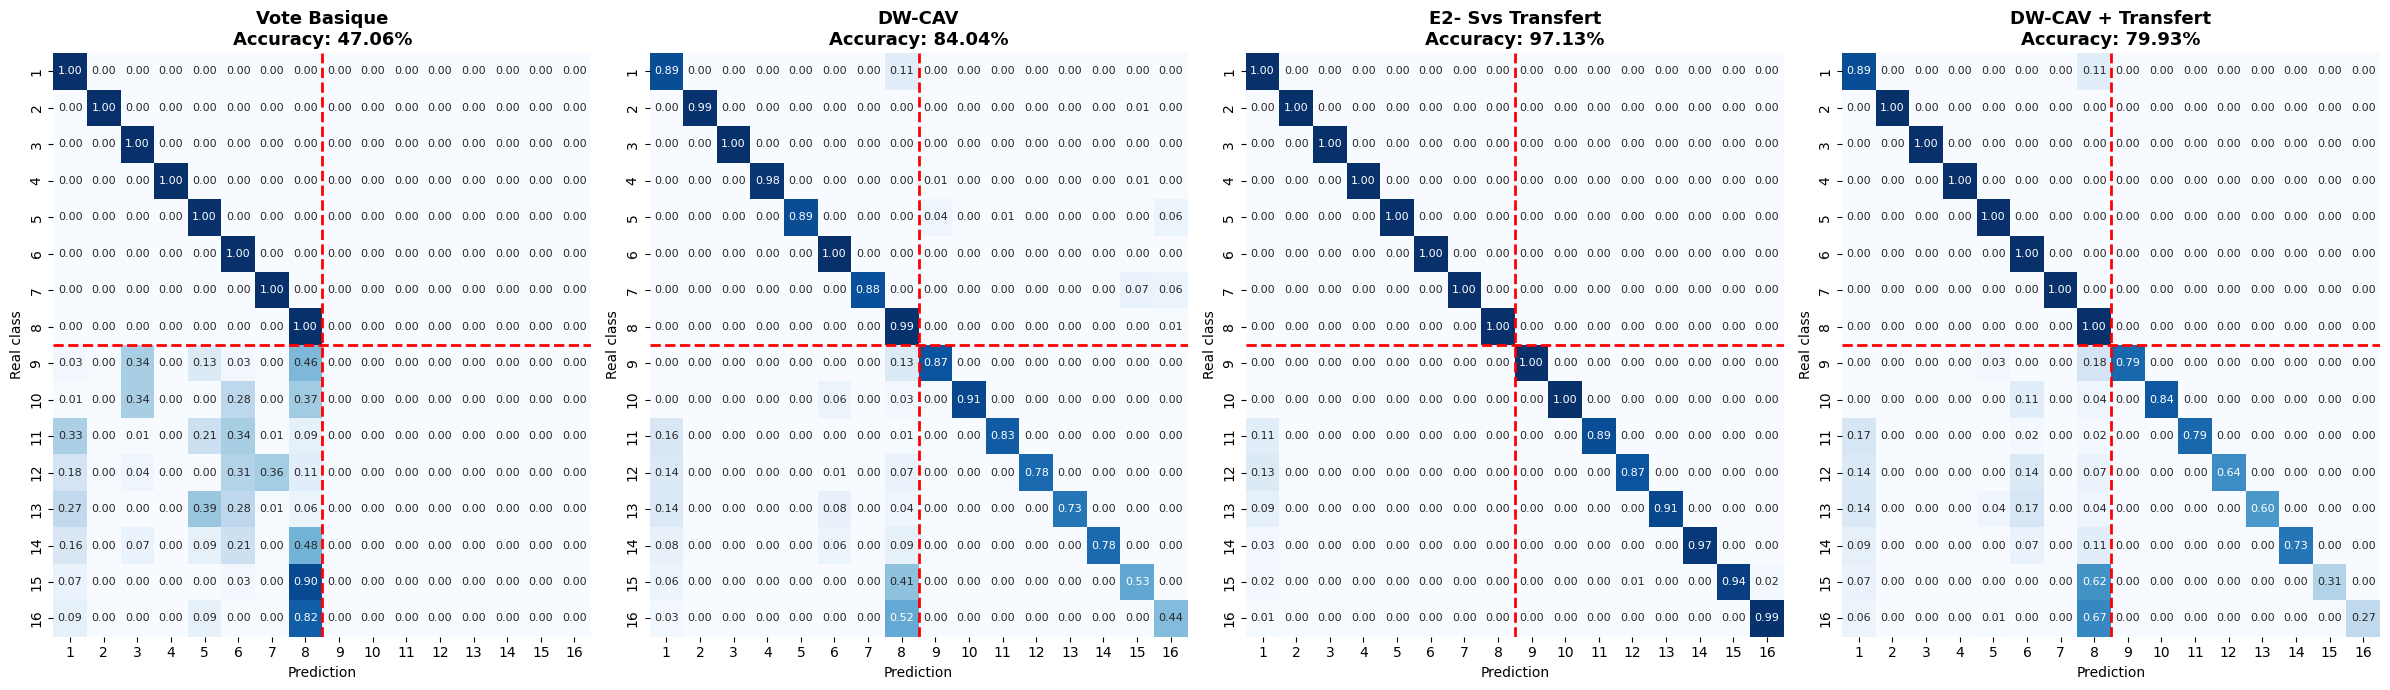

In [23]:
methods = [
    ("Vote Basique",         y_pred_basic,    acc_basic,    '#E53935'),
    ("DW-CAV",               y_pred_dwcav,    acc_dwcav,    '#2196F3'),
    ("E2- Svs Transfert",    y_pred_transfer, acc_transfer, '#FF9800'),
    ("DW-CAV + Transfert",   y_pred_dwcav_tr, acc_dwcav_tr, "#891C9C"),
]

# Confusion matrices
top3 = [methods[0], methods[1], methods[2], methods[3]]
fig, axes = plt.subplots(1, 4, figsize=(24, 7))
for ax, (name, y_pred, acc, _) in zip(axes, top3):
    cm = confusion_matrix(y_test_all, y_pred, labels=ALL_CLASSES)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ALL_CLASSES.astype(int),
                yticklabels=ALL_CLASSES.astype(int),
                ax=ax, vmin=0, vmax=1, cbar=False, annot_kws={'size': 8})
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Real class')
    ax.set_title(f"{name}\nAccuracy: {acc:.2%}", fontsize=13, fontweight='bold')
    ax.axhline(y=len(KNOWN_CLASSES), color='red', lw=2, ls='--')
    ax.axvline(x=len(KNOWN_CLASSES), color='red', lw=2, ls='--')
plt.tight_layout()
plt.savefig('confusion_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

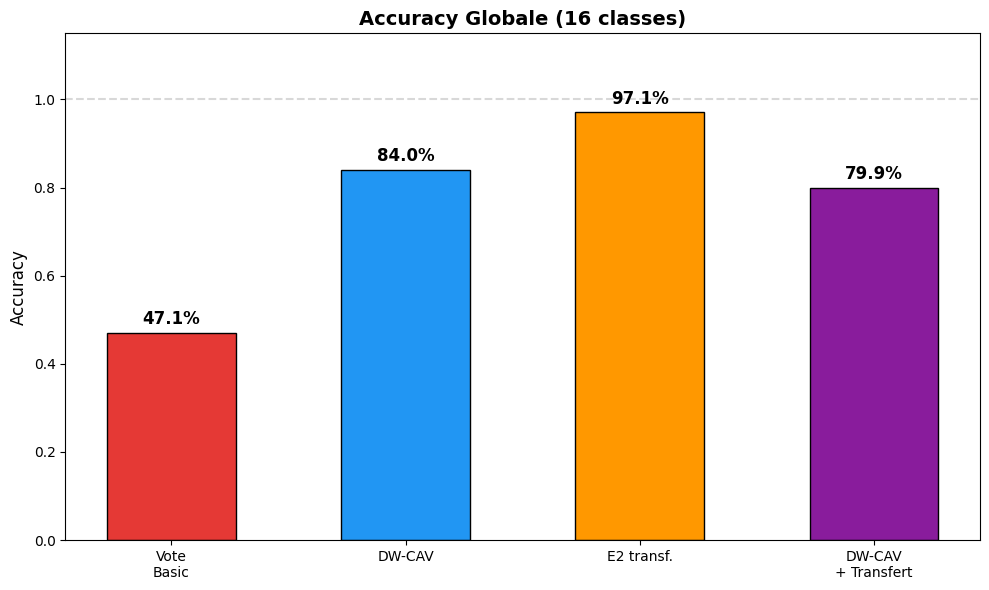

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

names_short = ['Vote\nBasic', 'DW-CAV', 'E2 transf.', 'DW-CAV\n+ Transfert']
accs_all = [m[2] for m in methods]
colors_all = [m[3] for m in methods]

bars = ax.bar(names_short, accs_all, color=colors_all, edgecolor='black', width=0.55)
for bar, a in zip(bars, accs_all):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{a:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.15])
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Globale (16 classes)', fontsize=14, fontweight='bold')
ax.axhline(1.0, color='gray', ls='--', alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()